# Analysis of TikTok data

### Download the videos using the data

In [10]:
import pandas as pd

# # Load your CSV
# df = pd.read_csv("tiktok_videos_detailed.csv")

# # Save only the video_url column to a text file
# df["video_url"].to_csv("video_links.txt", index=False, header=False)


### Save downloaded videos

In [ ]:
# !yt-dlp -f mp4 -a video_links.txt -o "videos/%(uploader)s_%(id)s.%(ext)s" 
# this earlier i thought did not have audio but i think it probably did but i just opened the video with vscode preview and that could have explained the no sound.

Deprecated Feature: Support for Python version 3.9 has been deprecated. Please update to Python 3.10 or above
[TikTok] Extracting URL: https://www.tiktok.com/@winniehospital/video/7420904942640073990
[TikTok] 7420904942640073990: Downloading webpage
[info] 7420904942640073990: Downloading 1 format(s): bytevc1_720p_386245-1
[download] Destination: videos/7420904942640073990.mp4
[download] 100% of    2.93MiB in 00:00:00 at 3.96MiB/s0;33m00:000m


In [9]:
# !yt-dlp -a video_links.txt \
# -f "bestvideo+bestaudio/best" \
#   --merge-output-format mp4 \
#   -o "videos/%(id)s.%(ext)s"


In [ ]:
# !pip install easyocr

# !sudo apt-get install ffmpeg

# !pip install openai-whisper (from openai but it needs the ffmeg too)



Password:sudo: a password is required


✅ Done! Saved 56 transcripts into all_transcripts.csv


In [18]:
# !whisper videos/*.mp4 --model medium --language en --output_dir transcripts/


In [ ]:
# !ffmpeg -version


In [ ]:
import os
import pandas as pd

# Path to your transcripts folder
input_folder = "transcripts"
output_file = "all_transcripts.csv"

# Collect transcripts
data = []
for file_name in os.listdir(input_folder):
    if file_name.endswith(".txt"):
        file_path = os.path.join(input_folder, file_name)
        with open(file_path, "r", encoding="utf-8") as f:
            transcript = f.read().strip()
            data.append({"video_name": file_name, "transcript": transcript})

# Save to CSV
df = pd.DataFrame(data)
df.to_csv(output_file, index=False, encoding="utf-8")

print(f"✅ Done! Saved {len(df)} transcripts into {output_file}")

In [22]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Download stopwords if not already
nltk.download("stopwords")
from nltk.corpus import stopwords

# Load transcripts CSV
df = pd.read_csv("all_transcripts.csv")

# Define stopwords (English for now, can extend with Ghana-specific terms if needed)
stop_words = set(stopwords.words("english"))

# --- Step 1: Clean transcripts ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df["cleaned"] = df["transcript"].astype(str).apply(clean_text)

# --- Step 2: Word frequency counts ---
all_words = " ".join(df["cleaned"]).split()
word_freq = Counter(all_words).most_common(20)
print("✅ Top 20 Most Frequent Words:")
for word, freq in word_freq:
    print(f"{word}: {freq}")

# --- Step 3: Topic modeling (LDA) ---
# Vectorize
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(df["cleaned"])

# Fit LDA (try 5 topics — you can tune this)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)


✅ Top 20 Most Frequent Words:
nurse: 41
ghana: 41
like: 40
im: 33
go: 33
come: 29
uk: 27
going: 26
get: 24
work: 24
want: 23
dont: 22
also: 21
need: 20
make: 20
see: 20
know: 20
well: 19
sure: 19
thank: 19

Topic 1:
nurse | uk | clinical | research | work | nursing | jobs | care | registered | nmc

Topic 2:
nurses | ceo | company | visa | star | ghana | sponsor | ielts | like | watching

Topic 3:
like | ghana | come | going | im | got | nurse | want | work | need

Topic 4:
pain | okay | alright | im | ash | palm | dont | really | bang | oh

Topic 5:
tweed | oh | feel | speaks | language | wonderful | wala | illa | shes | care


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanubalad/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanubalad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Top 20 Most Frequent Words:
nurse: 41
ghana: 41
like: 40
im: 33
go: 33
come: 29
uk: 27
going: 26
get: 24
work: 24
want: 23
dont: 22
also: 21
need: 20
make: 20
see: 20
know: 20
well: 19
sure: 19
thank: 19

Topic 1: nurse | uk | clinical | research | work | nursing | jobs | care | registered | nmc

Topic 2: nurses | ceo | company | visa | star | ghana | sponsor | ielts | like | watching

Topic 3: like | ghana | come | going | im | got | nurse | want | work | need

Topic 4: pain | okay | alright | im | ash | palm | dont | really | bang | oh

Topic 5: tweed | oh | feel | speaks | language | wonderful | wala | illa | shes | care


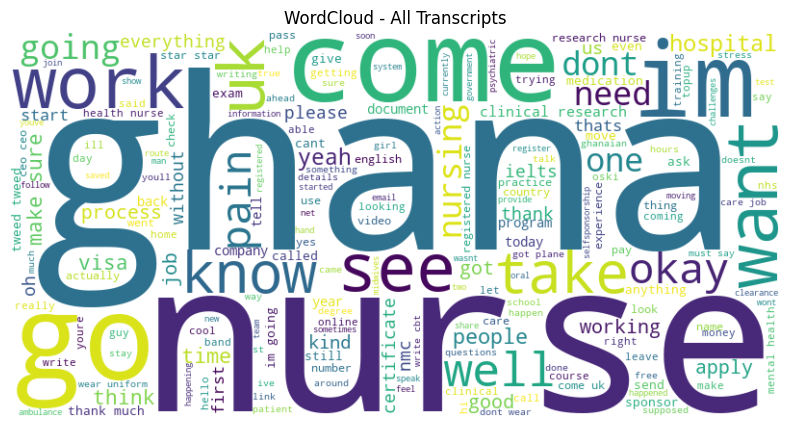

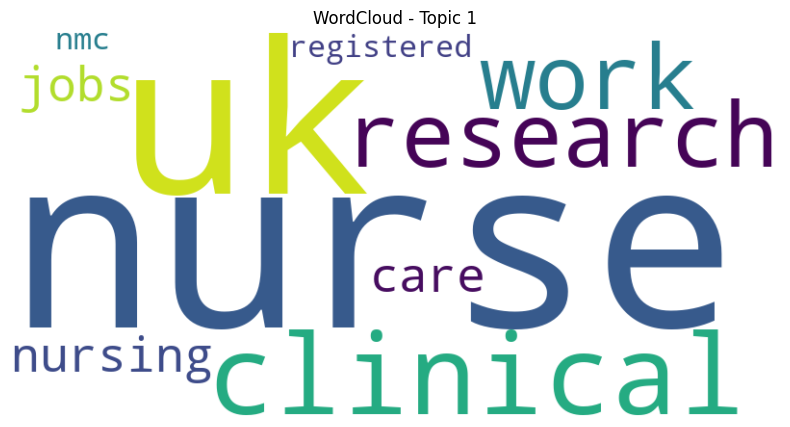

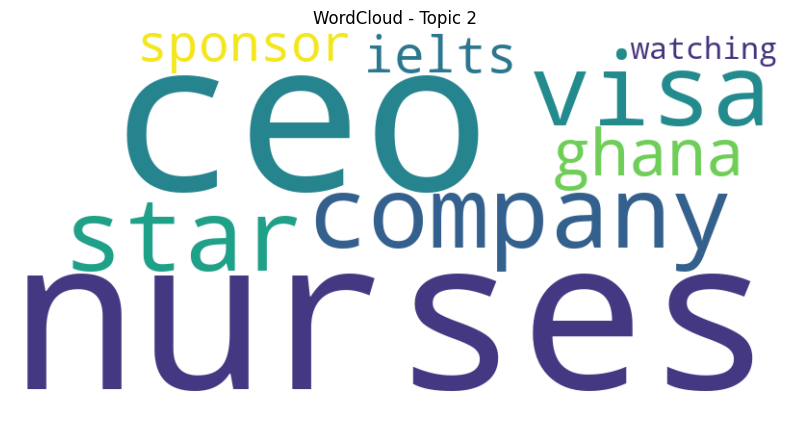

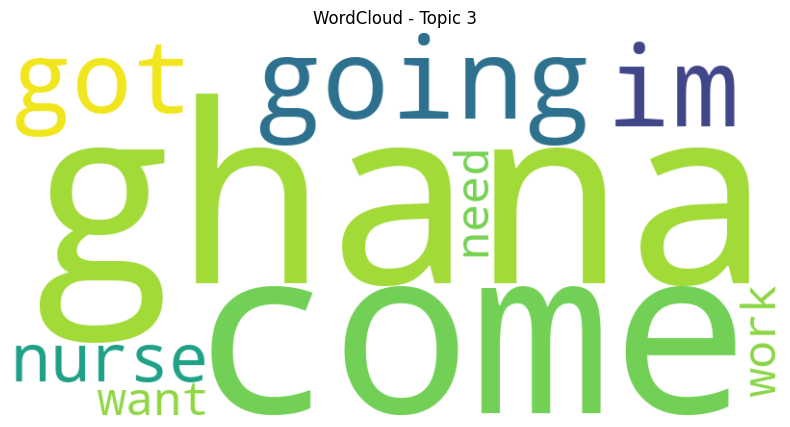

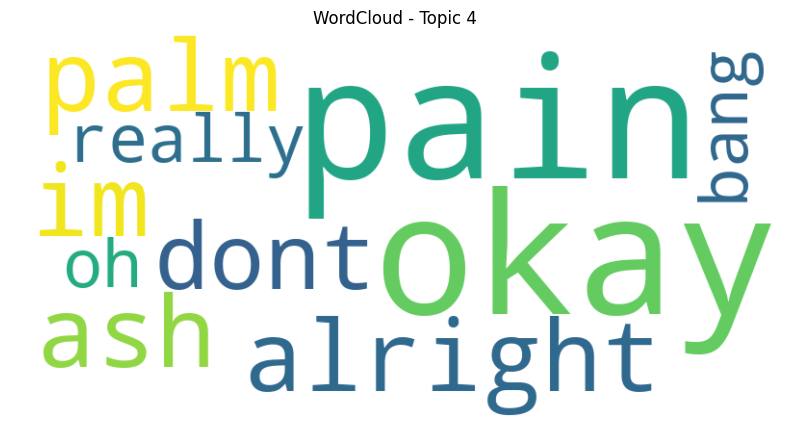

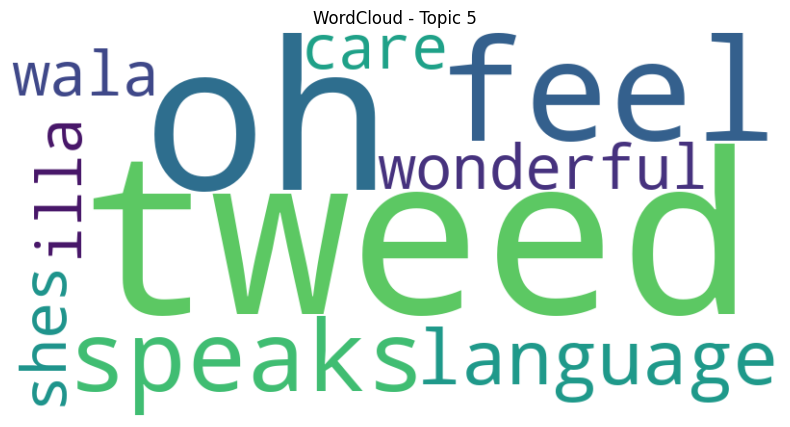

In [24]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- Setup ---
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load transcripts CSV
df = pd.read_csv("all_transcripts.csv")

# --- Step 1: Clean transcripts ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df["cleaned"] = df["transcript"].astype(str).apply(clean_text)

# --- Step 2: Word frequency counts ---
all_words = " ".join(df["cleaned"]).split()
word_freq = Counter(all_words).most_common(20)
print("✅ Top 20 Most Frequent Words:")
for word, freq in word_freq:
    print(f"{word}: {freq}")

# --- Step 3: Topic modeling (LDA) ---
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(df["cleaned"])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# --- Step 4: Display topics ---
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[idx] = words
        print(f"\nTopic {idx+1}: {' | '.join(words)}")
    return topics

topics = display_topics(lda, vectorizer.get_feature_names_out(), 10)

# --- Step 5: Wordcloud for all transcripts ---
wc_all = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["cleaned"]))
plt.figure(figsize=(10, 5))
plt.imshow(wc_all, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - All Transcripts")
plt.show()

# --- Step 6: Wordcloud per topic ---
for idx, words in topics.items():
    wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - Topic {idx+1}")
    plt.show()


In [25]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# --- Setup ---
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load transcripts
df = pd.read_csv("all_transcripts.csv")

# Clean function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters and spaces
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df["cleaned"] = df["transcript"].astype(str).apply(clean_text)

# --- Bigram & Trigram Analysis ---
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top bigrams
print("\n✅ Top 20 Bigrams:")
for phrase, freq in get_top_ngrams(df["cleaned"], ngram_range=(2,2)):
    print(f"{phrase}: {freq}")

# Top trigrams
print("\n✅ Top 20 Trigrams:")
for phrase, freq in get_top_ngrams(df["cleaned"], ngram_range=(3,3)):
    print(f"{phrase}: {freq}")



✅ Top 20 Bigrams:
make sure: 14
clinical research: 10
im going: 8
tweed tweed: 8
come uk: 7
star star: 7
ceo ceo: 7
mental health: 6
registered nurse: 6
write osce: 5
write cbt: 5
nmc ghana: 5
dont wear: 5
wear uniform: 5
nurse ghana: 5
nmc uk: 5
got plane: 5
alright ash: 5
thanks watching: 4
care jobs: 4

✅ Top 20 Trigrams:
star star star: 6
ceo ceo ceo: 6
dont wear uniform: 5
tweed tweed tweed: 5
mental health nurses: 3
consider band writing: 3
wear uniform dont: 3
uniform dont wear: 3
register nmc uk: 3
spend billions spend: 3
feel oh feel: 3
oh feel oh: 3
oh sorry hear: 3
come uk work: 3
uk work nurse: 3
clinical research nurse: 3
bang bang bang: 3
hi guys girl: 2
update update update: 2
tier sponsorship visa: 2


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanubalad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



✅ Top Bigrams: [('make sure', np.int64(14)), ('clinical research', np.int64(10)), ('im going', np.int64(8)), ('tweed tweed', np.int64(8)), ('come uk', np.int64(7)), ('star star', np.int64(7)), ('ceo ceo', np.int64(7)), ('mental health', np.int64(6)), ('registered nurse', np.int64(6)), ('write osce', np.int64(5)), ('write cbt', np.int64(5)), ('nmc ghana', np.int64(5)), ('dont wear', np.int64(5)), ('wear uniform', np.int64(5)), ('nurse ghana', np.int64(5))]

✅ Top Trigrams: [('star star star', np.int64(6)), ('ceo ceo ceo', np.int64(6)), ('dont wear uniform', np.int64(5)), ('tweed tweed tweed', np.int64(5)), ('mental health nurses', np.int64(3)), ('consider band writing', np.int64(3)), ('wear uniform dont', np.int64(3)), ('uniform dont wear', np.int64(3)), ('register nmc uk', np.int64(3)), ('spend billions spend', np.int64(3)), ('feel oh feel', np.int64(3)), ('oh feel oh', np.int64(3)), ('oh sorry hear', np.int64(3)), ('come uk work', np.int64(3)), ('uk work nurse', np.int64(3))]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanubalad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


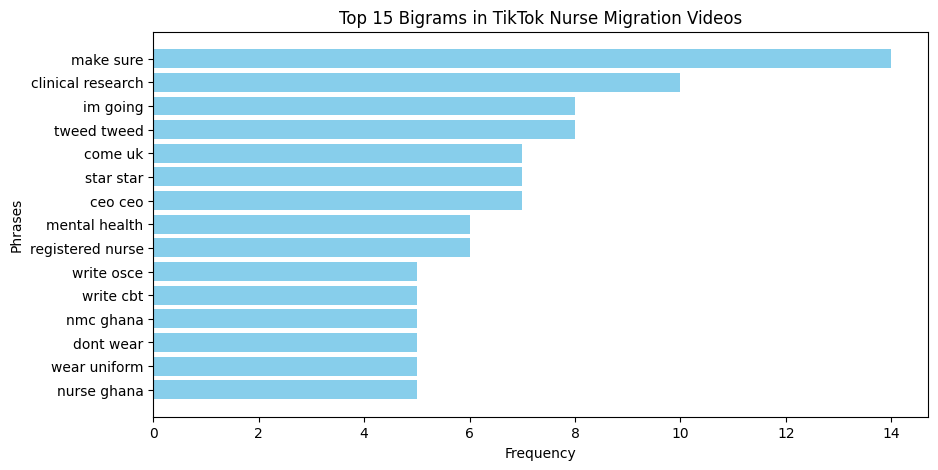

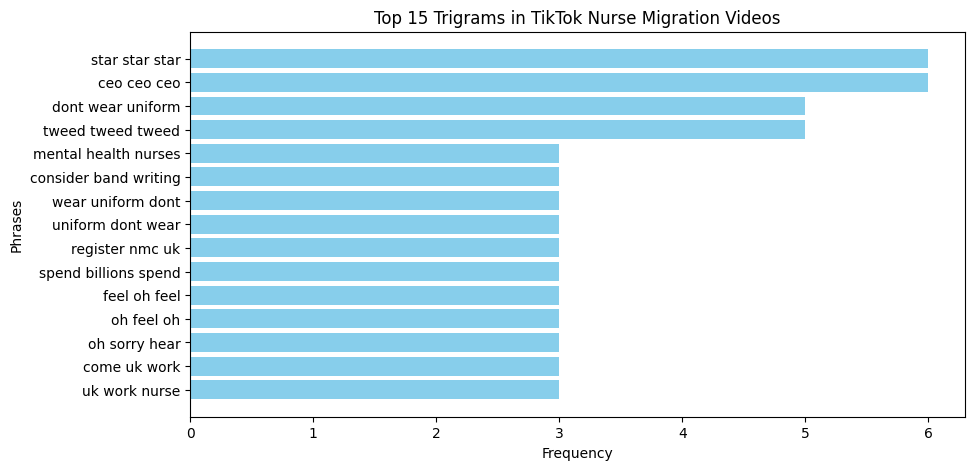

In [26]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import matplotlib.pyplot as plt

# --- Setup ---
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

# Load transcripts
df = pd.read_csv("all_transcripts.csv")

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters and spaces
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df["cleaned"] = df["transcript"].astype(str).apply(clean_text)

# --- N-gram extraction function ---
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# --- Visualization function ---
def plot_ngrams(ngrams, title):
    phrases, freqs = zip(*ngrams)
    plt.figure(figsize=(10,5))
    plt.barh(phrases[::-1], freqs[::-1], color="skyblue")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Phrases")
    plt.show()

# --- Run Bigram & Trigram Analysis ---
bigrams = get_top_ngrams(df["cleaned"], ngram_range=(2,2), n=15)
trigrams = get_top_ngrams(df["cleaned"], ngram_range=(3,3), n=15)

print("\n✅ Top Bigrams:", bigrams)
print("\n✅ Top Trigrams:", trigrams)

# --- Plot results ---
plot_ngrams(bigrams, "Top 15 Bigrams in TikTok Nurse Migration Videos")
plot_ngrams(trigrams, "Top 15 Trigrams in TikTok Nurse Migration Videos")


In [27]:
import pandas as pd
from transformers import pipeline

# Load transcripts
df = pd.read_csv("all_transcripts.csv")

# --- Step 1: Sentiment Analysis ---
sentiment_analyzer = pipeline("sentiment-analysis")

# Run sentiment prediction
df["sentiment"] = df["transcript"].astype(str).apply(lambda x: sentiment_analyzer(x[:512])[0]["label"])

# --- Step 2: Emotion Analysis ---
# You can use a model fine-tuned for emotions, e.g. "j-hartmann/emotion-english-distilroberta-base"
emotion_analyzer = pipeline("text-classification", 
                            model="j-hartmann/emotion-english-distilroberta-base", 
                            return_all_scores=False)

# Run emotion prediction
df["emotion"] = df["transcript"].astype(str).apply(lambda x: emotion_analyzer(x[:512])[0]["label"])

# --- Step 3: Save results ---
df.to_csv("transcripts_with_sentiment_emotion.csv", index=False)

print("✅ Analysis complete. Results saved to transcripts_with_sentiment_emotion.csv")
print(df[["transcript", "sentiment", "emotion"]].head())


/Users/kanubalad/miniforge3/envs/migration/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0
Device set to use mps:0
/Users/kanubalad/miniforge3/envs/migration/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


✅ Analysis complete. Results saved to transcripts_with_sentiment_emotion.csv
                                          transcript sentiment   emotion
0  And finally, as I said in the beginning,\nif y...  POSITIVE   neutral
1  Hi guys, this is your girl Abinom Mercedes. I'...  POSITIVE   neutral
2  They are not helping registered nurses who wan...  POSITIVE  surprise
3  Allah, la ilaha illa huwa al-hayyu al-qayyum\n...  NEGATIVE   neutral
4  Oh lord I won't stop for nothing, victory's ne...  POSITIVE  surprise


/var/folders/cf/xgy1fywj3q1bylrhvlp36psc0000gn/T/ipykernel_10733/3849511766.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, palette="Set2")


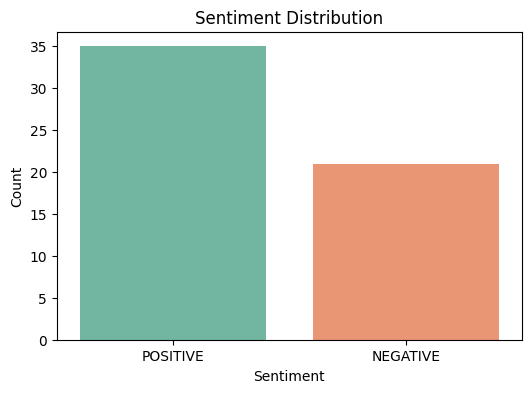

/var/folders/cf/xgy1fywj3q1bylrhvlp36psc0000gn/T/ipykernel_10733/3849511766.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="emotion", data=df, order=df["emotion"].value_counts().index, palette="Set3")


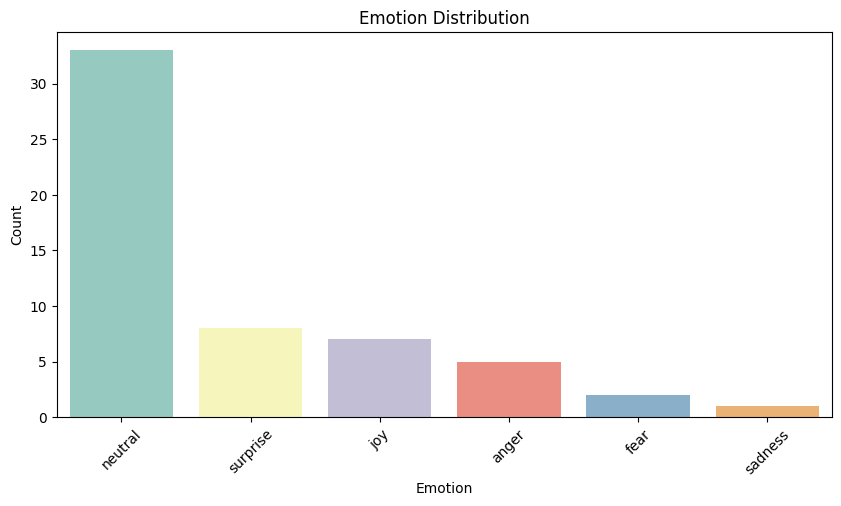

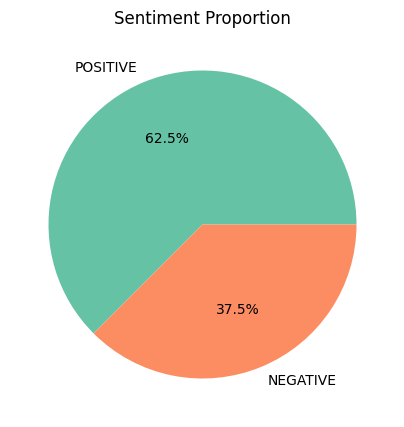

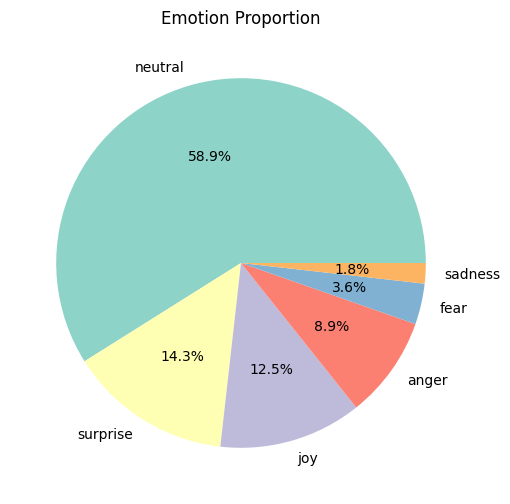

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load annotated transcripts
df = pd.read_csv("transcripts_with_sentiment_emotion.csv")

# --- Sentiment distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df, palette="Set2")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# --- Emotion distribution ---
plt.figure(figsize=(10,5))
sns.countplot(x="emotion", data=df, order=df["emotion"].value_counts().index, palette="Set3")
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# --- Proportions (optional pie chart) ---
sentiment_counts = df["sentiment"].value_counts(normalize=True)
emotion_counts = df["emotion"].value_counts(normalize=True)

plt.figure(figsize=(5,5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", colors=sns.color_palette("Set2"))
plt.title("Sentiment Proportion")
plt.show()

plt.figure(figsize=(6,6))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct="%1.1f%%", colors=sns.color_palette("Set3"))
plt.title("Emotion Proportion")
plt.show()
